In [43]:
import tensorflow as tf

# Must come before any TensorFlow GPU initialization
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)


✅ Memory growth enabled for GPUs


In [44]:
#importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [45]:
train_images_dir = r"/kaggle/input/ai-vs-human-generated-dataset/train_data"
test_images_dir = r"/kaggle/input/ai-vs-human-generated-dataset/test_data_v2"

# Custom paths to Read the CSV files (change as per your system settings or Kaggle notebook)
train_csv = pd.read_csv(r"/kaggle/input/ai-vs-human-generated-dataset/train.csv")
test_csv = pd.read_csv(r"/kaggle/input/ai-vs-human-generated-dataset/test.csv")


In [46]:
# Dropping the unnamed index column [Cleaning the dataset]
train_csv= train_csv.drop(train_csv.columns[0], axis=1)
print(train_csv.head())
print(test_csv.head())

                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [47]:
# Removing the 'train_data/' prefix from the 'file_name' column [Cleaning the dataset]
train_csv['file_name'] = train_csv['file_name'].str.replace('train_data/', '', regex=False)
print(train_csv.head())

                              file_name  label
0  a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  041be3153810433ab146bc97d5af505c.jpg      0
2  615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  8542fe161d9147be8e835e50c0de39cd.jpg      0
4  5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [48]:
'''When using flow_from_dataframe with class_mode='binary', 
the y_col values (in this case, the label column) must be strings, such as "0" and "1", 
instead of integers like 0 and 1 and to overcome TypeError: If class_mode="binary", 
y_col="label" column values must be strings.'''

train_csv['label'] = train_csv['label'].astype(str)

In [49]:
# Removing the 'test_data/' prefix from the 'id' column [Cleaning the dataset]
test_csv['id'] = test_csv['id'].str.replace('test_data_v2/', '', regex=False)
print(test_csv.head())

                                     id
0  1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  eb364dd2dfe34feda0e52466b7ce7956.jpg
3  f76c2580e9644d85a741a42c6f6b39c0.jpg
4  a16495c578b7494683805484ca27cf9f.jpg


In [50]:
# To split the train folder for training and validation as we have separate data for testing
# test_size = 0.25 is to meet approximately the size of test folder

train_data, val_data = train_test_split(train_csv, test_size=0.30, random_state=42) 

In [51]:
len(train_data)

55965

In [52]:
len(val_data)

23985

In [53]:
IMG_SIZE = (128, 128)  # Resizing all the images
BATCH_SIZE = 96

# Data augmentation for training

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=(0.8,1.0),
    horizontal_flip=True
)

# Rescaling for validation and test data

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Training generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_images_dir,
    x_col='file_name',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Validation generator

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=train_images_dir,
    x_col='file_name',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=test_images_dir,
    x_col='id',
    y_col=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 55965 validated image filenames belonging to 2 classes.
Found 23985 validated image filenames belonging to 2 classes.
Found 5540 validated image filenames.


In [54]:
# Initializing an empty sequential model

prediction_model = Sequential()

In [55]:
# Defining and adding layers to the model

prediction_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # First Conv layer
    MaxPool2D((2, 2)),  # First Pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Second Conv layer
    MaxPool2D((2, 2)),  # Second Pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # Third Conv layer
    MaxPool2D((2, 2)),  # Third Pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # Forth Conv layer
    MaxPool2D((2, 2)),  # Forth Pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # Fifth Conv layer
    MaxPool2D((2, 2)),  # Fifth Pooling layer
    Flatten(),  # Flatten before Dense layers
    Dense(units=256, activation="relu", 
          kernel_initializer="random_normal", 
          bias_initializer="random_normal"),  # First Dense layer
    Dropout(0.2),
    Dense(units=128, activation="relu", 
          kernel_initializer="random_normal", 
          bias_initializer="random_normal"),  # Second Dense layer
    Dropout(0.2),
    Dense(units=1, activation="sigmoid", 
          kernel_initializer="random_uniform", 
          bias_initializer="random_uniform")  # Output layer
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
# Hyper-Parameters setting for an optimizer

Adam_optimizer = Adam(learning_rate= 0.001, beta_1 = 0.90, beta_2 = 0.90, epsilon = 1e-10)

In [57]:
# Compiling the build model

prediction_model.compile(
    loss = "binary_crossentropy", optimizer = Adam_optimizer, metrics = ["accuracy"]
)

prediction_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 572,097 (2.18 MB)

 Trainable params: 572,097 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# from tensorflow.keras.optimizers import SGD

# sgd_optimizer = SGD(learning_rate=0.01)

# prediction_model.compile(
#     loss="binary_crossentropy",
#     optimizer=sgd_optimizer, 
#     metrics=["accuracy"]
# )

# prediction_model.summary()

In [59]:
# from tensorflow.keras.optimizers import SGD

# sgd_momentum_optimizer = SGD(learning_rate=0.01, momentum=0.9)

# prediction_model.compile(
#     loss="binary_crossentropy",
#     optimizer=sgd_momentum_optimizer, 
#     metrics=["accuracy"]
# )

# prediction_model.summary()

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Print messages when stopping
    mode='min',             # Stop when the quantity monitored has stopped decreasing
    restore_best_weights=True # Restores model weights from the epoch with the best value
)

In [61]:
# plotting the architecture of the build model

# plot_model(prediction_model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [66]:
import tensorflow as tf

# This will list all physical devices TensorFlow can see.
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"Kaggle is using the following GPU(s): {gpu_devices}")
else:
    print("GPU not found. Check your notebook settings in the right sidebar.")

Kaggle is using the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [67]:
# Training the model with 25 epochs and 96 as the size of the batch
# The process also includes finding validation accuracy and f1_score, confusion matrix for the 25% of Training data

EPOCHS = 20

history = prediction_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=early_stopping
)

Epoch 1/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 465s 790ms/step - accuracy: 0.8843 - loss: 0.2899 - val_accuracy: 0.7264 - val_loss: 0.7800
Epoch 2/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 463s 788ms/step - accuracy: 0.9112 - loss: 0.2282 - val_accuracy: 0.8051 - val_loss: 0.4617
Epoch 3/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 454s 772ms/step - accuracy: 0.9240 - loss: 0.2044 - val_accuracy: 0.6962 - val_loss: 0.9194
Epoch 4/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 458s 778ms/step - accuracy: 0.9331 - loss: 0.1770 - val_accuracy: 0.8265 - val_loss: 0.5542
Epoch 5/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 467s 793ms/step - accuracy: 0.9379 - loss: 0.1672 - val_accuracy: 0.7866 - val_loss: 0.7473
Epoch 6/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 477s 812ms/step - accuracy: 0.9383 - loss: 0.1671 - val_accuracy: 0.8271 - val_loss: 0.8023
Epoch 7/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 478s 812ms/step - accuracy: 0.9417 - loss: 0.1563 - val_accuracy: 0.8295 - val_loss: 0.7294
Epoch 7: early stopping
Restoring model weights from the end of the best epo

ValueError: x and y must have same first dimension, but have shapes (1,) and (7,)

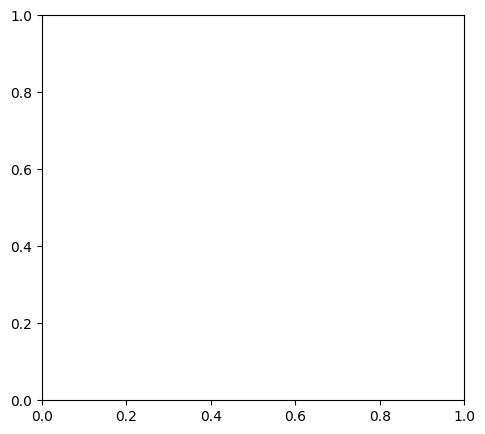

In [70]:
import matplotlib.pyplot as plt

# --- Retrieve history from training ---
# Training loss
train_loss = history.history['loss']
# Validation loss
val_loss = history.history['val_loss']

# Training accuracy
train_acc = history.history['accuracy']
# Validation accuracy
val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs_range = range(1, 2)

# --- Create the plots ---
plt.figure(figsize=(12, 5)) # Create a figure to hold the plots

# --- Plot Training & Validation Loss ---
plt.subplot(1, 2, 1) # Create the first subplot in a 1x2 grid
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# --- Plot Training & Validation Accuracy ---
plt.subplot(1, 2, 2) # Create the second subplot in a 1x2 grid
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# --- Show the plots ---
plt.show()

In [71]:
# Predicting the probabilities on the validation set
val_predictions_prob = prediction_model.predict(val_generator)

# Converting probabilities to binary labels
val_predictions = (val_predictions_prob > 0.5).astype(int).flatten()

# Extracting true labels from val_data
val_true_labels = val_data['label'].astype(int).to_numpy()

# Calculating the metrics
accuracy = accuracy_score(val_true_labels, val_predictions)
f1 = f1_score(val_true_labels, val_predictions)
conf_matrix = confusion_matrix(val_true_labels, val_predictions)

# Displaying the metrics
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation F1 Score: {f1:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 373ms/step
Validation Accuracy: 0.50
Validation F1 Score: 0.58
Confusion Matrix:
[[3848 8087]
 [3844 8206]]


In [74]:
# saving the model

prediction_model.save("prediction_model.keras")

In [75]:
# Loading the saved model

Prediction_model_AI_Human_generated_Image = load_model("prediction_model.keras")

# Predicting probabilities for the test images

test_predictions = Prediction_model_AI_Human_generated_Image.predict(test_generator)

# Converting probabilities to the binary labels

test_predicted_labels = (test_predictions > 0.5).astype(int)

# Adding the predictions to the test DataFrame

test_csv['label'] = test_predicted_labels

# Saving  the predictions to a CSV file

test_csv.to_csv("test.csv", index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step


In [80]:
# Load the model to predict the class of any sample image

prediction_model_AI_Human_generated_Image = load_model("prediction_model.keras")

# Path to the single image

image_path = r"/kaggle/input/human-created-image-sample/Screenshot 2025-01-04 234506.png"

# Load and preprocess the image

img_size = (128, 128)  # changing with the input size of your model
image = load_img(image_path, target_size=img_size)
image_array = img_to_array(image)  # Converting image to a numpy array
image_array = np.expand_dims(image_array, axis=0)  # Adding batch dimension
image_array = image_array / 255.0  # Normalizing to [0, 1] if your model requires it

# Predicting the probability
single_prediction = prediction_model_AI_Human_generated_Image.predict(image_array)

# Extracting the probability
probability = single_prediction[0][0]  # Assuming binary classification, single output node

# Converting the probability to binary class label
predicted_label = (probability > 0.5).astype(int)

# Output the results
print(f"Predicted probability: {probability}")
print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Predicted probability: 0.02031831070780754
Predicted label: 0
